# Data Exploration and Model Building

This notebook guides you through the process of exploring your data and building a predictive model.

## 1. Setup and Data Loading

First, let's import the necessary libraries and load our data.

In [1]:
import os

# Check the exact path being used
expected_path = os.path.abspath(os.path.join('..', 'src', 'modeling.py'))
print(f"Looking for modeling.py at: {expected_path}")
print(f"File exists: {os.path.exists(expected_path)}")

# Read the first few lines to confirm it's the correct file
if os.path.exists(expected_path):
    with open(expected_path, 'r') as f:
        content = f.read(500)  # Read first 500 characters
        print("First few lines of the file:")
        print(content)

Looking for modeling.py at: /workspaces/IDRPublic/src/modeling.py
File exists: True
First few lines of the file:
import pandas as pd
import numpy as np
from typing import Optional, List, Dict, Any, Tuple
import pickle
from pathlib import Path

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,  # Regression metrics
    acc


In [2]:
import importlib.util
import sys

# Load the module directly from the file path
expected_path = '/workspaces/IDRPublic/src/modeling.py'
spec = importlib.util.spec_from_file_location("modeling_direct", expected_path)
modeling_direct = importlib.util.module_from_spec(spec)
sys.modules["modeling_direct"] = modeling_direct
spec.loader.exec_module(modeling_direct)

# Check if the function exists in the loaded module
print("Function exists in direct import:", hasattr(modeling_direct, "get_numeric_and_categorical_columns"))

# Try to access the function
if hasattr(modeling_direct, "get_numeric_and_categorical_columns"):
    print("Function signature:", modeling_direct.get_numeric_and_categorical_columns.__annotations__)

Function exists in direct import: True
Function signature: {'df': <class 'pandas.core.frame.DataFrame'>, 'return': typing.Tuple[typing.List[str], typing.List[str]]}


In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Set plotting style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

# Import custom modules (adjust the path if needed)
import sys
print("Current sys.path:", sys.path)  # Print current system path
sys.path.append('../src')
print("Updated sys.path:", sys.path)  # Check if path was updated correctly

# Try importing each module separately and print confirmation
try:
    from data_loader import load_excel_data, clean_data, split_data
    print("✓ Successfully imported data_loader module")
    # Optionally print function signatures to verify they're the ones you expect
    print(f"   - load_excel_data: {load_excel_data.__doc__}")
except ImportError as e:
    print("✗ Failed to import data_loader:", e)

try:
    from visualization import plot_numeric_distribution, plot_correlation_matrix, plot_feature_importance
    print("✓ Successfully imported visualization module")
except ImportError as e:
    print("✗ Failed to import visualization:", e)

try:
    from modeling import (get_numeric_and_categorical_columns, create_preprocessing_pipeline,
                        evaluate_regression_models, evaluate_classification_models)
    print("✓ Successfully imported modeling module")
except ImportError as e:
    print("✗ Failed to import modeling:", e)

# Test if one function from each module works with minimal inputs
print("\nTesting minimal function calls:")
try:
    # Choose simple functions that won't require complex inputs
    print("Testing get_numeric_and_categorical_columns...")
    # Create a simple test dataframe
    test_df = pd.DataFrame({
        'numeric_col': [1, 2, 3],
        'categorical_col': ['A', 'B', 'C']
    })
    num_cols, cat_cols = get_numeric_and_categorical_columns(test_df)
    print(f"   - Numeric columns: {num_cols}")
    print(f"   - Categorical columns: {cat_cols}")
except Exception as e:
    print("Function test failed:", e)

Current sys.path: ['/usr/local/python/3.12.1/lib/python312.zip', '/usr/local/python/3.12.1/lib/python3.12', '/usr/local/python/3.12.1/lib/python3.12/lib-dynload', '', '/home/codespace/.local/lib/python3.12/site-packages', '/usr/local/python/3.12.1/lib/python3.12/site-packages', '../src', '../src']
Updated sys.path: ['/usr/local/python/3.12.1/lib/python312.zip', '/usr/local/python/3.12.1/lib/python3.12', '/usr/local/python/3.12.1/lib/python3.12/lib-dynload', '', '/home/codespace/.local/lib/python3.12/site-packages', '/usr/local/python/3.12.1/lib/python3.12/site-packages', '../src', '../src', '../src']
✓ Successfully imported data_loader module
   - load_excel_data: 
    Load data from an Excel file into a pandas DataFrame.
    
    Parameters:
    -----------
    file_path : str
        Path to the Excel file
    sheet_name : str, optional
        Name of the sheet to load. If None, the first sheet is loaded.
        
    Returns:
    --------
    pd.DataFrame
        The loaded data
  

In [8]:
# Load Excel file
file_path = "../data/raw/2023-q1-federal-idr-puf.xlsx"


# Reading in the second sheet
sheet_name = 'OON Emergency and Non-Emergency'
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Display the first few rows to confirm it worked
print(f"Successfully loaded sheet: {sheet_name}")
print(f"Shape of dataframe: {df.shape}")
print("\nFirst 5 rows:")
df.head()

Successfully loaded sheet: OON Emergency and Non-Emergency
Shape of dataframe: (65271, 30)

First 5 rows:


,Dispute Number,DLI Number,Payment Determination Outcome,Default Decision,Type of Dispute,Provider/Facility Group Name,Provider/Facility Name,Provider Email Domain,Provider/Facility NPI Number,Practice/Facility Size,...,Location of Service,Practice/Facility Specialty or Type,Provider/Facility Offer as Percent of QPA,Health Plan/Issuer Offer as Percent of QPA,Offer Selected from Provider or Issuer,Prevailing Party Offer as Percent of QPA,QPA as Percent of Median QPA,Provider/Facility Offer as Percent of Median Provider/Facility Offer Amount,Health Plan/Issuer Offer as Percent of Median Health Plan/Issuer Offer Amount,Prevailing Offer as Percent of Median Prevailing Offer Amount
0,DISP-135724,DLI - 582653,In Favor of Plan/Issuer,No,Single,LONGHORN EMERGENCY MEDICAL ASSOCIATES PA,"BLUDWORTH MD,WHITNEY G",teamhealth.com,1649669672,101-500 Employees,...,TX,EMERGENCY MEDICINE,1.64,1,In Favor of Plan/Issuer,1,1,0.99,1,1
1,DISP-135637,DLI - 582530,In Favor of Plan/Issuer,No,Single,NR,ROXBOROUGH MEMORIAL HOSPITAL,primehealthcare.com,NR,Over 500 Employees,...,PA,ACUTE CARE HOSPITAL,5.13,0.7,In Favor of Plan/Issuer,0.7,1,1,1,1
2,DISP-135495,DLI - 582345,In Favor of Provider/Facility/AA Provider,No,Single,WOODLANDS EMERGENCY PHYSICIANS,WOODLANDS EMERGENCY PHYSICIANS,r1rcm.com,1467989871,51-100 Employees,...,TX,Emergency Provider,3.19,1.15,In Favor of Provider/Facility/AA Provider,3.19,0.27,0.83,0.92,0.88
3,DISP-135654,DLI - 582547,In Favor of Provider/Facility/AA Provider,No,Single,APP OF TENNESSEE ED PLLC,APP OF TENNESSEE ED PLLC,r1rcm.com,1003230236,101-500 Employees,...,TN,EmergencyMedicine,2.47,1.15,In Favor of Provider/Facility/AA Provider,2.47,0.96,0.71,1.15,0.71
4,DISP-135828,DLI - 582852,In Favor of Provider/Facility/AA Provider,No,Batched,Remote Neuromonitoring Physicians PC,Remote Neuromonitoring Physicians PC,specialtycare.net,1124253075,Over 500 Employees,...,PA,Intraoperative Neuromonitoring,11.04,0,In Favor of Provider/Facility/AA Provider,11.04,0.95,1,*,1


In [9]:
# Loading the other sheet from the Excel file
QPA_sheet = 'QPA and Offers'
df_QPA = pd.read_excel('../data/raw/2023-q1-federal-idr-puf.xlsx', sheet_name=QPA_sheet)

# Display basic info about this sheet
print(f"Successfully loaded sheet: {QPA_sheet}")
print(f"Shape of dataframe: {df_QPA.shape}")
print("\nFirst 5 rows of QPA and Offers data:")
df_QPA.head()

Successfully loaded sheet: QPA and Offers
Shape of dataframe: (68007, 9)

First 5 rows of QPA and Offers data:


,Service Code,Place of Service Code,Geographical Region,QPA,Provider/Facility Offer,Health Plan/Issuer Offer,Offer Selected from Provider or Issuer,Prevailing Offer,Default Decision
0,A0436,42.0,"Aberdeen, WA",^,^,^,In Favor of Provider/Facility/AA Provider,^,No
1,A0431,42.0,"Aberdeen, WA",^,^,^,In Favor of Provider/Facility/AA Provider,^,No
2,A0431,42.0,"Aberdeen, WA",^,^,^,In Favor of Provider/Facility/AA Provider,^,No
3,A0431,42.0,"Aberdeen, WA",^,^,^,In Favor of Provider/Facility/AA Provider,^,No
4,A0431,42.0,"Aberdeen, WA",^,^,^,In Favor of Provider/Facility/AA Provider,^,No


## 2. Data Cleaning and Preprocessing

Let's clean the data and perform some basic preprocessing.

In [10]:
# Basic data exploration
print("Column names in main dataframe:")
for col in df.columns:
    print(f"- {col}")

# Check for missing values
print("\nMissing values per column:")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percent
})
missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False)

Column names in main dataframe:
- Dispute Number
- DLI Number
- Payment Determination Outcome
- Default Decision
- Type of Dispute
- Provider/Facility Group Name
- Provider/Facility Name
- Provider Email Domain
- Provider/Facility NPI Number
- Practice/Facility Size
- Health Plan/Issuer Name
- Health Plan/Issuer Email Domain
- Health Plan Type
- Length of Time to Make Determination
- IDRE Compensation
- Dispute Line Item Type
- Type of Service Code
- Service Code
- Place of Service Code
- Item or Service Description
- Location of Service
- Practice/Facility Specialty or Type
- Provider/Facility Offer as Percent of QPA
- Health Plan/Issuer Offer as Percent of QPA
- Offer Selected from Provider or Issuer
- Prevailing Party Offer as Percent of QPA
- QPA as Percent of Median QPA
- Provider/Facility Offer as Percent of Median Provider/Facility Offer Amount
- Health Plan/Issuer Offer as Percent of Median Health Plan/Issuer Offer Amount
- Prevailing Offer as Percent of Median Prevailing Offer

,Missing Values,Percentage
Health Plan/Issuer Offer as Percent of QPA,11747,17.997273
Provider/Facility Offer as Percent of QPA,6985,10.701537
Place of Service Code,594,0.910052
Location of Service,594,0.910052
Prevailing Party Offer as Percent of QPA,168,0.257388
Item or Service Description,107,0.163932
Type of Service Code,107,0.163932
Default Decision,17,0.026045
Service Code,2,0.003064


In [11]:
# Clean the data
clean_df = clean_data(df)

# Display information about the cleaned data
print("Data information:")
clean_df.info()

# Display summary statistics
print("\nSummary statistics:")
display(clean_df.describe())

# Check for missing values
print("\nMissing values per column:")
display(clean_df.isna().sum())

# Identify numeric and categorical columns
numeric_cols, categorical_cols = get_numeric_and_categorical_columns(clean_df)
print(f"\nNumeric columns: {numeric_cols}")
print(f"Categorical columns: {categorical_cols}")

# Let's examine a sample of categorical columns if any exist
if categorical_cols:
    for col in categorical_cols[:3]:  # Show first 3 at most
        print(f"\nUnique values in {col}:")
        display(clean_df[col].value_counts())

Cleaning summary:
  Original shape: (65271, 30)
  Cleaned shape: (65271, 30)
Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65271 entries, 0 to 65270
Data columns (total 30 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   dispute_number                                                                 65271 non-null  object 
 1   dli_number                                                                     65271 non-null  object 
 2   payment_determination_outcome                                                  65271 non-null  object 
 3   default_decision                                                               65254 non-null  object 
 4   type_of_dispute                                                                65271 non-null  object 
 5   provider/facility_group_name       

,length_of_time_to_make_determination,place_of_service_code
count,65271.000000,64677.000000
mean,61.032419,22.406342
std,29.997159,1.444833
min,13.000000,0.000000
25%,41.000000,22.000000
50%,52.000000,23.000000
75%,73.000000,23.000000
max,210.000000,82.000000



Missing values per column:


dispute_number                                                                       0
dli_number                                                                           0
payment_determination_outcome                                                        0
default_decision                                                                    17
type_of_dispute                                                                      0
provider/facility_group_name                                                         0
provider/facility_name                                                               0
provider_email_domain                                                                0
provider/facility_npi_number                                                         0
practice/facility_size                                                               0
health_plan/issuer_name                                                              0
health_plan/issuer_email_domain            


Numeric columns: ['length_of_time_to_make_determination', 'place_of_service_code']
Categorical columns: ['dispute_number', 'dli_number', 'payment_determination_outcome', 'default_decision', 'type_of_dispute', 'provider/facility_group_name', 'provider/facility_name', 'provider_email_domain', 'provider/facility_npi_number', 'practice/facility_size', 'health_plan/issuer_name', 'health_plan/issuer_email_domain', 'health_plan_type', 'idre_compensation', 'dispute_line_item_type', 'type_of_service_code', 'service_code', 'item_or_service_description', 'location_of_service', 'practice/facility_specialty_or_type', 'provider/facility_offer_as_percent_of_qpa', 'health_plan/issuer_offer_as_percent_of_qpa', 'offer_selected_from_provider_or_issuer', 'prevailing_party_offer_as_percent_of_qpa', 'qpa_as_percent_of_median_qpa', 'provider/facility_offer_as_percent_of_median_provider/facility_offer_amount', 'health_plan/issuer_offer_as_percent_of_median_health_plan/issuer_offer_amount', 'prevailing_offer_

dispute_number
DISP-163082    330
DISP-128485    318
DISP-110576    221
DISP-148607    196
DISP-110744    185
              ... 
DISP-206790      1
DISP-206609      1
DISP-206658      1
DISP-206619      1
DISP-206744      1
Name: count, Length: 24289, dtype: int64


Unique values in dli_number:


dli_number
DLI - 581619    1
DLI - 582653    1
DLI - 582530    1
DLI - 582345    1
DLI - 582547    1
               ..
DLI - 673064    1
DLI - 582689    1
DLI - 582679    1
DLI - 582776    1
DLI - 582294    1
Name: count, Length: 65271, dtype: int64


Unique values in payment_determination_outcome:


payment_determination_outcome
In Favor of Provider/Facility/AA Provider    44543
In Favor of Plan/Issuer                      20544
NR                                              95
Split Decision                                  89
Name: count, dtype: int64

# This is a key step where I filtered out of batched and bundled cases, leaving us with Single cases only

In [12]:
# Filter the main dataframe to include only 'Single' cases
# First, let's check the unique values in the "Type of Dispute" column
print("Unique values in 'Type of Dispute' column:")
print(df["Type of Dispute"].unique())

# Now filter for only Single cases
df_single = df[df["Type of Dispute"] == "Single"]
print(f"\nFiltered for Single cases only")
print(f"Original dataframe shape: {df.shape}")
print(f"Filtered dataframe shape: {df_single.shape}")
print(f"Percentage of Single cases: {df_single.shape[0]/df.shape[0]*100:.2f}%")

# Display the first few rows of the filtered data
print("\nFirst 5 rows of filtered data:")
df_single.head()

Unique values in 'Type of Dispute' column:
['Single' 'Batched']

Filtered for Single cases only
Original dataframe shape: (65271, 30)
Filtered dataframe shape: (21917, 30)
Percentage of Single cases: 33.58%

First 5 rows of filtered data:


,Dispute Number,DLI Number,Payment Determination Outcome,Default Decision,Type of Dispute,Provider/Facility Group Name,Provider/Facility Name,Provider Email Domain,Provider/Facility NPI Number,Practice/Facility Size,...,Location of Service,Practice/Facility Specialty or Type,Provider/Facility Offer as Percent of QPA,Health Plan/Issuer Offer as Percent of QPA,Offer Selected from Provider or Issuer,Prevailing Party Offer as Percent of QPA,QPA as Percent of Median QPA,Provider/Facility Offer as Percent of Median Provider/Facility Offer Amount,Health Plan/Issuer Offer as Percent of Median Health Plan/Issuer Offer Amount,Prevailing Offer as Percent of Median Prevailing Offer Amount
0,DISP-135724,DLI - 582653,In Favor of Plan/Issuer,No,Single,LONGHORN EMERGENCY MEDICAL ASSOCIATES PA,"BLUDWORTH MD,WHITNEY G",teamhealth.com,1649669672,101-500 Employees,...,TX,EMERGENCY MEDICINE,1.64,1,In Favor of Plan/Issuer,1,1,0.99,1,1
1,DISP-135637,DLI - 582530,In Favor of Plan/Issuer,No,Single,NR,ROXBOROUGH MEMORIAL HOSPITAL,primehealthcare.com,NR,Over 500 Employees,...,PA,ACUTE CARE HOSPITAL,5.13,0.7,In Favor of Plan/Issuer,0.7,1,1,1,1
2,DISP-135495,DLI - 582345,In Favor of Provider/Facility/AA Provider,No,Single,WOODLANDS EMERGENCY PHYSICIANS,WOODLANDS EMERGENCY PHYSICIANS,r1rcm.com,1467989871,51-100 Employees,...,TX,Emergency Provider,3.19,1.15,In Favor of Provider/Facility/AA Provider,3.19,0.27,0.83,0.92,0.88
3,DISP-135654,DLI - 582547,In Favor of Provider/Facility/AA Provider,No,Single,APP OF TENNESSEE ED PLLC,APP OF TENNESSEE ED PLLC,r1rcm.com,1003230236,101-500 Employees,...,TN,EmergencyMedicine,2.47,1.15,In Favor of Provider/Facility/AA Provider,2.47,0.96,0.71,1.15,0.71
6,DISP-135439,DLI - 582252,In Favor of Provider/Facility/AA Provider,No,Single,EMERGIGROUP PHYS ASSOC PLLC,EMERGIGROUP PHYS ASSOC PLLC,r1rcm.com,1831142769,51-100 Employees,...,TX,Emergency Provider,3.06,1.1,In Favor of Provider/Facility/AA Provider,3.06,0.28,0.83,0.92,0.88


In [23]:
# Identify columns with mixed types
def find_mixed_type_columns(df_single):
    mixed_cols = []
    for col in df_single.columns:
        if df_single[col].apply(type).nunique() > 1:
            mixed_cols.append(col)
    return mixed_cols

mixed_cols = find_mixed_type_columns(X_train)
print("Columns with mixed types:", mixed_cols)

Columns with mixed types: ['Default Decision', 'Provider/Facility NPI Number', 'IDRE Compensation', 'Type of Service Code', 'Service Code', 'Item or Service Description', 'Location of Service', 'Provider/Facility Offer as Percent of QPA', 'Health Plan/Issuer Offer as Percent of QPA', 'Prevailing Party Offer as Percent of QPA', 'QPA as Percent of Median QPA', 'Provider/Facility Offer as Percent of Median Provider/Facility Offer Amount', 'Health Plan/Issuer Offer as Percent of Median Health Plan/Issuer Offer Amount', 'Prevailing Offer as Percent of Median Prevailing Offer Amount']


## Implementing a data transformation step to address columns with non-uniform data type mismatch

In [13]:
# Addressing Place of Service, by starting with printing the original data type
print("Original data type:", df_single['Place of Service Code'].dtype)

# Step 1: Convert to string first (this preserves NaN as NaN)
df['pos_code_str'] = df['Place of Service Code'].astype(str)

# Step 2: Replace 'nan' strings with 'Unknown'
df.loc[df['pos_code_str'] == 'nan', 'pos_code_str'] = 'Unknown'

# Step 3: Remove the decimal points from the codes
df['pos_code_str'] = df['pos_code_str'].replace(r'\.0$', '', regex=True)

print("Sample values after conversion:", df['pos_code_str'].head())

# Step 4: Create a mapping dictionary with common POS codes
pos_mapping = {
    '11': 'Office',
    '21': 'Inpatient Hospital',
    '22': 'Outpatient Hospital',
    '23': 'Emergency Room - Hospital',
    '31': 'Skilled Nursing Facility',
    '32': 'Nursing Facility',
    '33': 'Custodial Care Facility',
    '65': 'End-Stage Renal Disease Treatment Facility',
    '81': 'Independent Laboratory',
    'Unknown': 'Missing POS Code'
    # Add others as needed for your dataset
}

# Step 5: Create a new column with descriptions
df['pos_description'] = df['pos_code_str'].map(pos_mapping)

# Print the results to check if mapping worked correctly
print("\nCheck if mapping worked correctly:")
print(df[['Place of Service Code', 'pos_code_str', 'pos_description']].head(10))

# Check if there are any missing mappings
missing_mappings = df['pos_description'].isna().sum()
print(f"\nNumber of records with missing mappings: {missing_mappings}")

if missing_mappings > 0:
    print("Unique POS codes without mappings:")
    unmapped_codes = df[df['pos_description'].isna()]['pos_code_str'].unique()
    print(sorted(unmapped_codes))
    
    # Optional: Handle any missing mappings
    df['pos_description'] = df['pos_description'].fillna('Other/Unknown POS')
    
# Optional: Convert the string column to categorical for efficiency
df['pos_code_cat'] = df['pos_code_str'].astype('category')
print("\nNew categorical column data type:", df['pos_code_cat'].dtype)

Original data type: float64
Sample values after conversion: 0    23
1    23
2    23
3    23
4    21
Name: pos_code_str, dtype: object

Check if mapping worked correctly:
   Place of Service Code pos_code_str            pos_description
0                   23.0           23  Emergency Room - Hospital
1                   23.0           23  Emergency Room - Hospital
2                   23.0           23  Emergency Room - Hospital
3                   23.0           23  Emergency Room - Hospital
4                   21.0           21         Inpatient Hospital
5                   21.0           21         Inpatient Hospital
6                   23.0           23  Emergency Room - Hospital
7                   23.0           23  Emergency Room - Hospital
8                   23.0           23  Emergency Room - Hospital
9                   23.0           23  Emergency Room - Hospital

Number of records with missing mappings: 2945
Unique POS codes without mappings:
['0', '12', '14', '15', '19', '2'

In [14]:
# 1. Standard approach - identify obvious categorical columns
obvious_categorical_cols = df_single.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Obvious categorical columns: {len(obvious_categorical_cols)}")

# 2. Identify potential numeric categorical variables
# Look for integer columns with few unique values (likely categorical)
numeric_cols = df_single.select_dtypes(include=['int64', 'float64']).columns.tolist()
potential_categorical = []

for col in numeric_cols:
    unique_count = df_single[col].nunique()
    # If column has relatively few unique values, it might be categorical
    if unique_count < 20:  # Threshold can be adjusted
        potential_categorical.append(col)
        print(f"Potential categorical column: {col} with {unique_count} unique values")

# 3. Combine all categorical variables
all_categorical = obvious_categorical_cols + potential_categorical
print(f"\nTotal categorical columns identified: {len(all_categorical)}")

# 4. Analyze each categorical variable
for col in all_categorical:
    # Get value counts
    value_counts = df_single[col].value_counts().sort_values(ascending=False)
    # Calculate percentage
    value_percent = df_single[col].value_counts(normalize=True).sort_values(ascending=False) * 100
    
    print(f"\n{'='*50}")
    print(f"Analysis of '{col}':")
    print(f"Number of unique values: {df_single[col].nunique()}")
    print(f"Missing values: {df_single[col].isna().sum()} ({df[col].isna().mean()*100:.2f}%)")
    
    # Show top categories
    print(f"\nTop categories (showing up to 10):")
    
    # Combine counts and percentages
    summary = pd.DataFrame({
        'Count': value_counts,
        'Percentage': value_percent
    }).head(10)
    
    print(summary)
    
    # Visualize if there are not too many categories
    if df_single[col].nunique() <= 15:
        plt.figure(figsize=(10, 6))
        sns.countplot(y=col, data=df_single, order=value_counts.index[:15])
        plt.title(f'Distribution of {col}')
        plt.xlabel('Count')
        plt.tight_layout()
        plt.savefig(f'categorical_dist_{col.replace("/", "_")}.png')
        plt.close()

Obvious categorical columns: 28
Potential categorical column: Place of Service Code with 16 unique values

Total categorical columns identified: 29

Analysis of 'Dispute Number':
Number of unique values: 18131
Missing values: 0 (0.00%)

Top categories (showing up to 10):
                Count  Percentage
Dispute Number                   
DISP-226234        45    0.205320
DISP-211665        43    0.196195
DISP-188889        41    0.187069
DISP-223998        41    0.187069
DISP-153310        39    0.177944
DISP-204150        37    0.168819
DISP-202647        36    0.164256
DISP-195408        35    0.159693
DISP-161288        34    0.155131
DISP-176235        33    0.150568

Analysis of 'DLI Number':
Number of unique values: 21917
Missing values: 0 (0.00%)

Top categories (showing up to 10):
              Count  Percentage
DLI Number                     
DLI - 582665      1    0.004563
DLI - 581619      1    0.004563
DLI - 582653      1    0.004563
DLI - 582530      1    0.004563
DLI - 58

In [12]:
# Create a proper ordering map that matches your data
size_order = {
    'Fewer than 20 Employees': 1,
    '20-50 Employees': 2,
    '51-100 Employees': 3,
    '101-500 Employees': 4,
    'Over 500 Employees': 5,
    'NR': 0  # Not Reported - typically assign 0 or NaN
}

# Make an explicit copy to ensure we're not working with a view
df_single = df_single.copy()

# Create ordinal encoding using .loc to avoid the warning
df_single.loc[:, 'facility_size_ordinal'] = df_single['Practice/Facility Size'].map(size_order)

# Check the encoding
print("\nOrdinal encoding created successfully")
print(df_single[['Practice/Facility Size', 'facility_size_ordinal']].drop_duplicates().sort_values('facility_size_ordinal'))

# Handle missing values using .loc
df_single.loc[:, 'facility_size_ordinal'] = df_single['facility_size_ordinal'].replace(0, np.nan)

# For one-hot encoding, create another explicit copy
df_for_encoding = df_single.copy()
df_for_encoding.loc[df_for_encoding['Practice/Facility Size'] == 'NR', 'Practice/Facility Size'] = np.nan

# Now one-hot encode
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
facility_size_encoded = encoder.fit_transform(df_for_encoding[['Practice/Facility Size']].fillna('Missing'))

# Get the feature names
feature_names = [f"facility_size_{cat}" for cat in encoder.categories_[0][1:]]

# Create a DataFrame with the encoded columns
facility_size_df = pd.DataFrame(
    facility_size_encoded,
    columns=feature_names,
    index=df_single.index  # Use df_single.index instead of df.index
)

# Now you can add these columns to your main dataframe
df_single = pd.concat([df_single, facility_size_df], axis=1)
print("\nOne-hot encoding created with the following columns:")
print(facility_size_df.columns.tolist())


Ordinal encoding created successfully
      Practice/Facility Size  facility_size_ordinal
134                       NR                    0.0
32   Fewer than 20 Employees                    1.0
7            20-50 Employees                    2.0
2           51-100 Employees                    3.0
0          101-500 Employees                    4.0
1         Over 500 Employees                    5.0

One-hot encoding created with the following columns:
['facility_size_20-50 Employees', 'facility_size_51-100 Employees', 'facility_size_Fewer than 20 Employees', 'facility_size_Missing', 'facility_size_Over 500 Employees']


In [13]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import pandas as pd

# Check which parameter to use for sparsity
try:
    # Try the newer version parameter first
    encoder = OneHotEncoder(sparse_output=False, drop='first')
except TypeError:
    # Fall back to older version parameter
    encoder = OneHotEncoder(sparse=False, drop='first')

# Get the encoded columns
facility_size_encoded = encoder.fit_transform(df[['Practice/Facility Size']])

# Get the feature names
try:
    # Newer versions use get_feature_names_out
    feature_names = encoder.get_feature_names_out(['Practice/Facility Size'])
except AttributeError:
    # Older versions use get_feature_names
    feature_names = encoder.get_feature_names(['Practice/Facility Size'])

# Create a DataFrame with the encoded columns
facility_size_df = pd.DataFrame(
    facility_size_encoded,
    columns=feature_names
)

print(f"Created {facility_size_df.shape[1]} encoded columns for facility size")

Created 5 encoded columns for facility size


Distribution of Payment Determination Outcome:
Payment Determination Outcome
In Favor of Provider/Facility/AA Provider    14555
In Favor of Plan/Issuer                       7346
NR                                              13
Split Decision                                   3
Name: count, dtype: int64

Percentage distribution:
In Favor of Provider/Facility/AA Provider: 66.41%
In Favor of Plan/Issuer: 33.52%
NR: 0.06%
Split Decision: 0.01%


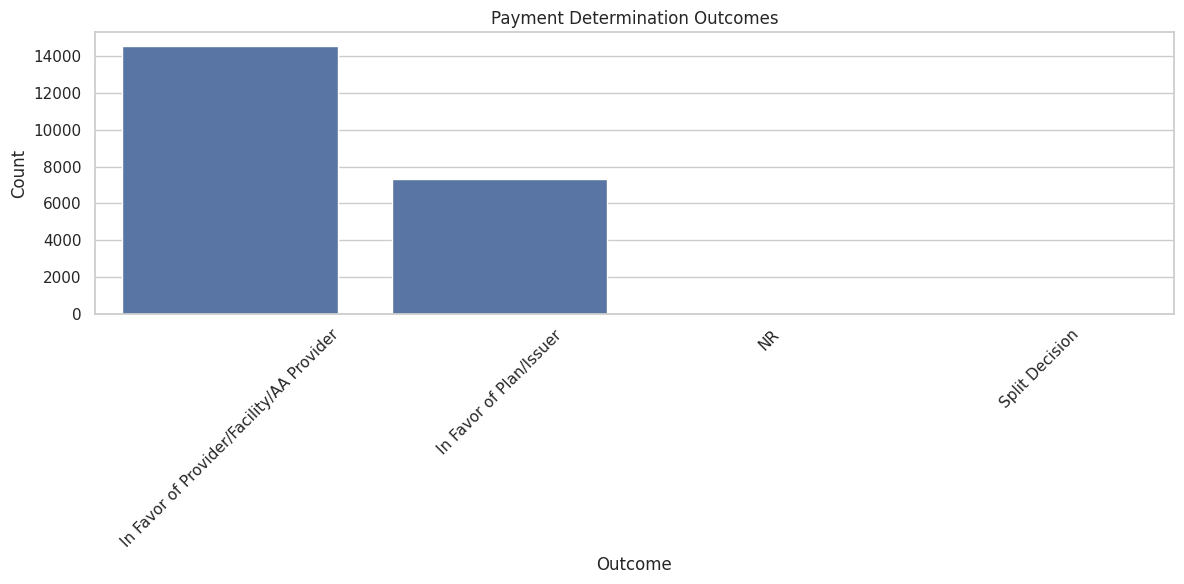

In [15]:
# Explore the Payment Determination Outcome variable
print("Distribution of Payment Determination Outcome:")
outcome_counts = df_single['Payment Determination Outcome'].value_counts()
print(outcome_counts)

# Calculate percentages
outcome_pcts = outcome_counts / outcome_counts.sum() * 100
print("\nPercentage distribution:")
for outcome, pct in outcome_pcts.items():
    print(f"{outcome}: {pct:.2f}%")

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=outcome_counts.index, y=outcome_counts.values)
plt.title('Payment Determination Outcomes')
plt.ylabel('Count')
plt.xlabel('Outcome')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Data Visualization

Let's visualize the data to understand it better.

In [16]:
print(df_single.columns.tolist())

['Dispute Number', 'DLI Number', 'Payment Determination Outcome', 'Default Decision', 'Type of Dispute', 'Provider/Facility Group Name', 'Provider/Facility Name', 'Provider Email Domain', 'Provider/Facility NPI Number', 'Practice/Facility Size', 'Health Plan/Issuer Name', 'Health Plan/Issuer Email Domain', 'Health Plan Type', 'Length of Time to Make Determination', 'IDRE Compensation', 'Dispute Line Item Type', 'Type of Service Code', 'Service Code', 'Place of Service Code', 'Item or Service Description', 'Location of Service', 'Practice/Facility Specialty or Type', 'Provider/Facility Offer as Percent of QPA', 'Health Plan/Issuer Offer as Percent of QPA', 'Offer Selected from Provider or Issuer', 'Prevailing Party Offer as Percent of QPA', 'QPA as Percent of Median QPA', 'Provider/Facility Offer as Percent of Median Provider/Facility Offer Amount', 'Health Plan/Issuer Offer as Percent of Median Health Plan/Issuer Offer Amount', 'Prevailing Offer as Percent of Median Prevailing Offer Am

In [17]:
# Replace 'length_of_time_to_make_determination' with 'Length of Time to Make Determination'
numeric_cols = ['Length of Time to Make Determination']

Type of numeric_cols: <class 'list'>
Contents of numeric_cols: ['Length of Time to Make Determination', 'Place of Service Code']
After filtering non-strings: ['Length of Time to Make Determination', 'Place of Service Code']
Distribution of numeric features:


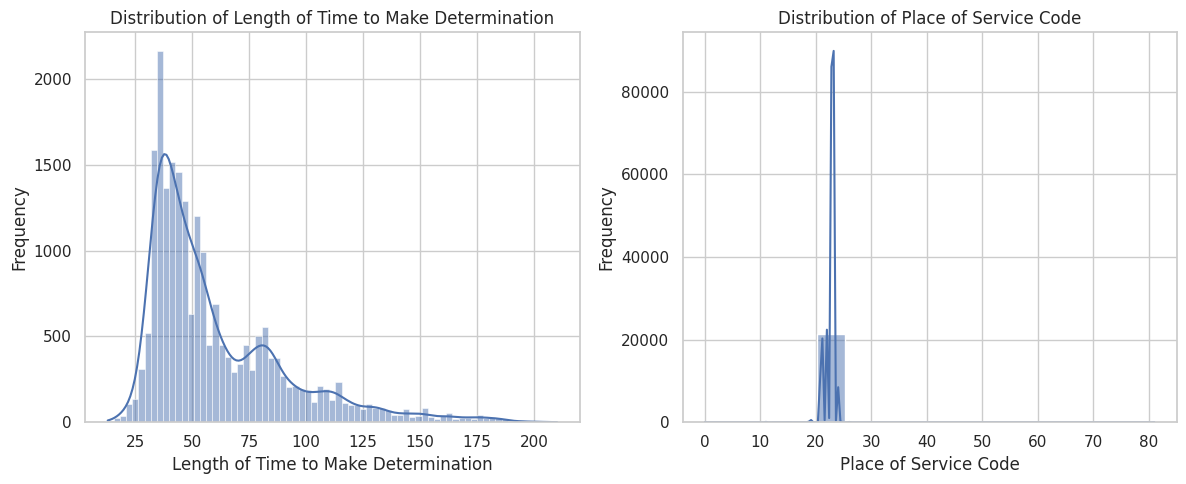

In [17]:
# Debug the numeric_cols list
print("Type of numeric_cols:", type(numeric_cols))
print("Contents of numeric_cols:", numeric_cols)

# Filter out any non-string elements
valid_numeric_cols = [col for col in numeric_cols if isinstance(col, str)]
print("After filtering non-strings:", valid_numeric_cols)

# Now use the filtered list
if valid_numeric_cols:
    print("Distribution of numeric features:")
    plot_numeric_distribution(df_single, valid_numeric_cols)
else:
    print("No valid numeric columns to plot after filtering.")

Distribution of numeric features:


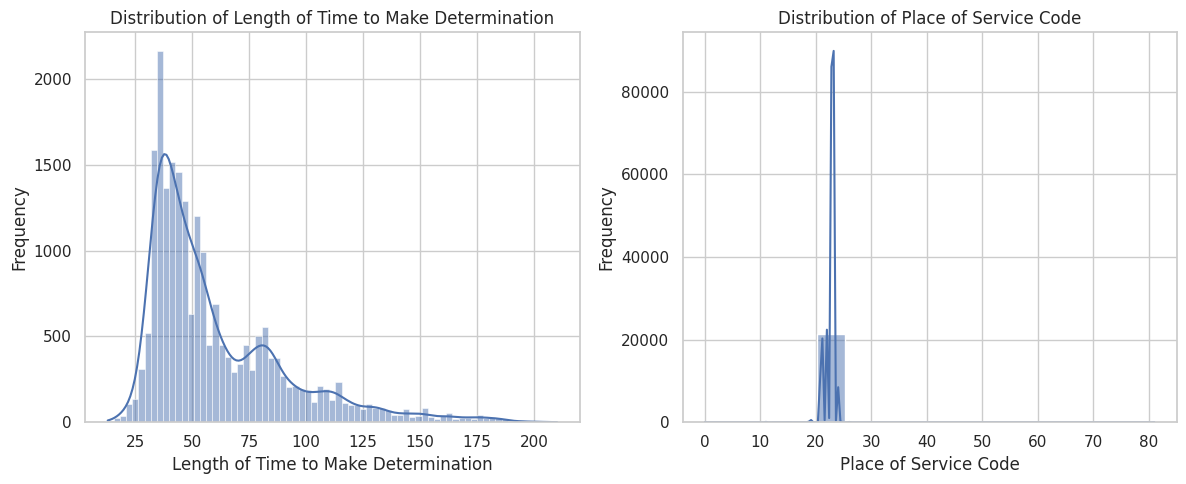

In [18]:
# Distribution of numeric features
if numeric_cols:
    print("Distribution of numeric features:")
    plot_numeric_distribution(df_single, numeric_cols)

Correlation matrix:


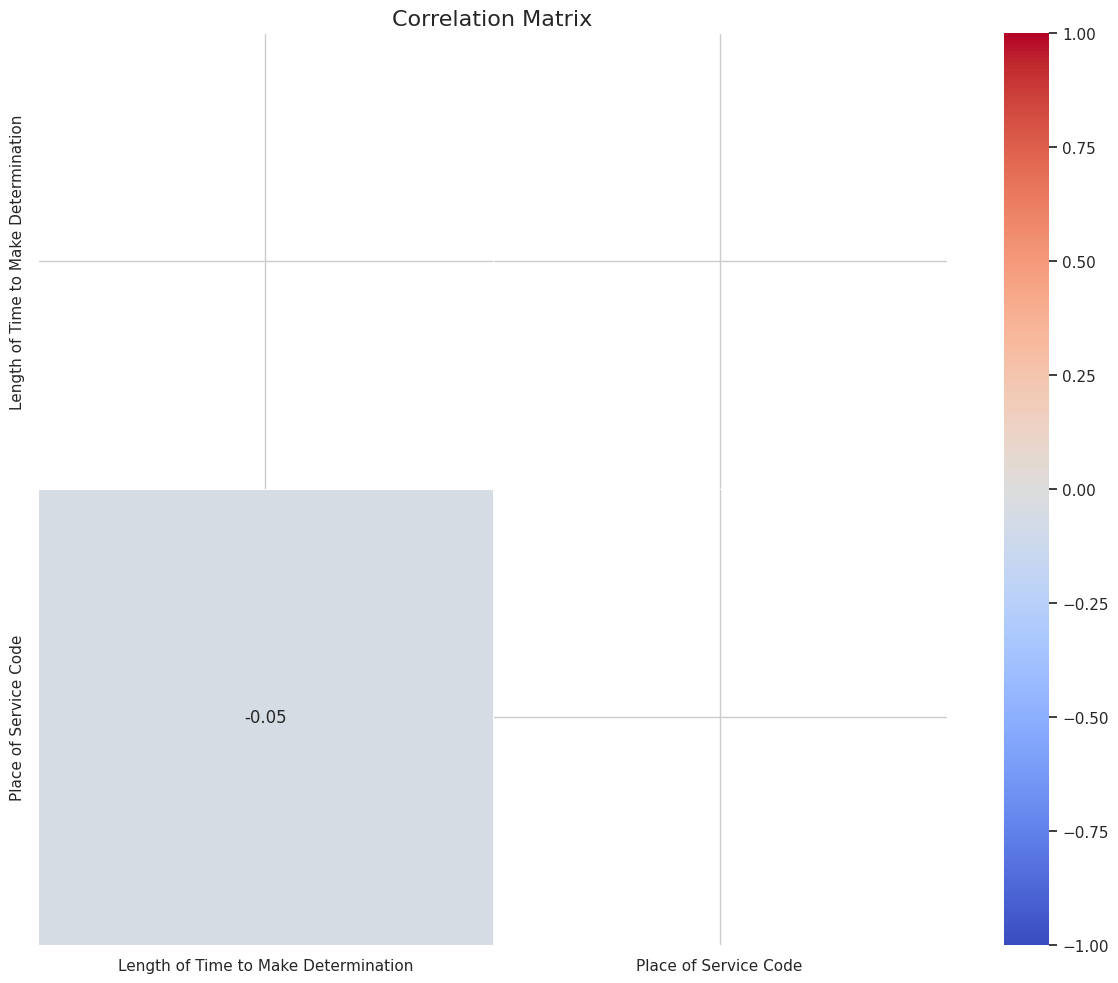

In [19]:
# Correlation matrix
if len(numeric_cols) > 1:
    print("Correlation matrix:")
    plot_correlation_matrix(df_single, numeric_cols)

## 4. Selecting Target Variable

Now, let's select the target variable for our predictive model.

Available columns for target variable:
0. Dispute Number
1. DLI Number
2. Payment Determination Outcome
3. Default Decision
4. Type of Dispute
5. Provider/Facility Group Name
6. Provider/Facility Name
7. Provider Email Domain
8. Provider/Facility NPI Number
9. Practice/Facility Size
10. Health Plan/Issuer Name
11. Health Plan/Issuer Email Domain
12. Health Plan Type
13. Length of Time to Make Determination
14. IDRE Compensation
15. Dispute Line Item Type
16. Type of Service Code
17. Service Code
18. Place of Service Code
19. Item or Service Description
20. Location of Service
21. Practice/Facility Specialty or Type
22. Provider/Facility Offer as Percent of QPA
23. Health Plan/Issuer Offer as Percent of QPA
24. Offer Selected from Provider or Issuer
25. Prevailing Party Offer as Percent of QPA
26. QPA as Percent of Median QPA
27. Provider/Facility Offer as Percent of Median Provider/Facility Offer Amount
28. Health Plan/Issuer Offer as Percent of Median Health Plan/Issuer Offer Amount
2

Payment Determination Outcome
In Favor of Provider/Facility/AA Provider    14555
In Favor of Plan/Issuer                       7346
NR                                              13
Split Decision                                   3
Name: count, dtype: int64

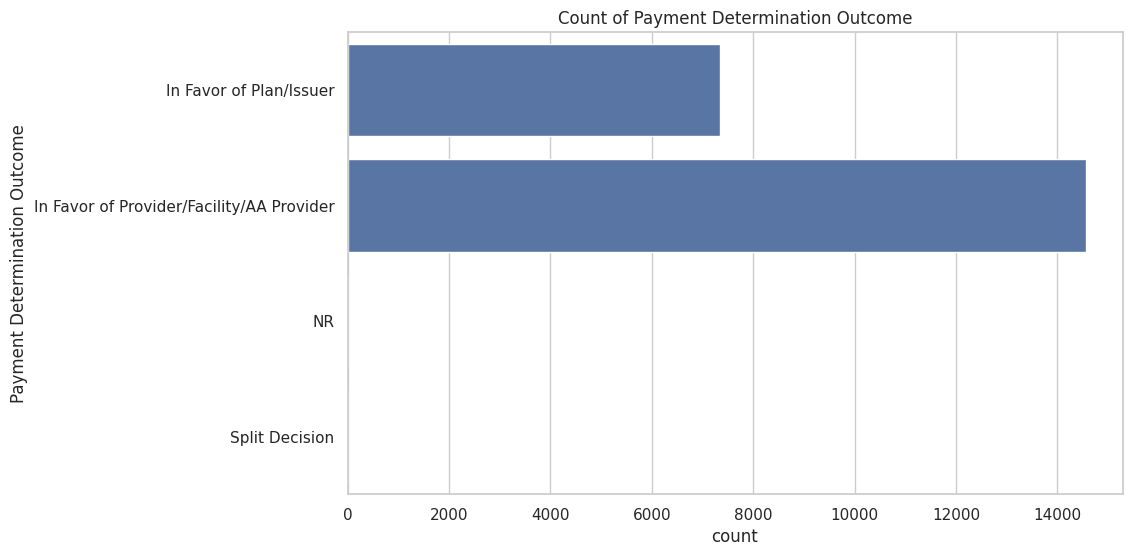


This appears to be a classification problem, in predicting: Payment Determination Outcome


In [20]:
# List all columns for user to select as target
print("Available columns for target variable:")
for i, col in enumerate(df_single.columns):
    print(f"{i}. {col}")

# Defining our target variable
target_column = 'Payment Determination Outcome'  

# Check data type of target variable to determine if this is a regression or classification problem
if target_column in df_single.columns:
    print(f"\nTarget variable: {target_column}")
    print(f"Data type: {df_single[target_column].dtype}")
    
    # For numeric target, show distribution
    if pd.api.types.is_numeric_dtype(df_single[target_column]):
        print("\nTarget distribution:")
        plt.figure(figsize=(10, 6))
        sns.histplot(df_single[target_column], kde=True)
        plt.title(f'Distribution of {target_column}')
        plt.show()
        
        problem_type = 'regression'
        print("\nThis appears to be a regression problem.")
    else:
        # For categorical target, show value counts
        print("\nTarget value counts:")
        display(df_single[target_column].value_counts())
        
        plt.figure(figsize=(10, 6))
        sns.countplot(y=df_single[target_column])
        plt.title(f'Count of {target_column}')
        plt.show()
        
        problem_type = 'classification'
        print(f"\nThis appears to be a classification problem, in predicting: {target_column}")
else:
    print(f"Error: '{target_column}' not found in the data. Please select a valid column.")

## 5. Data Splitting

Split the data into training and testing sets.

In [21]:
# Split the data - make sure to use your actual target column name
try:
    X_train, X_test, y_train, y_test = split_data(df_single, target_column)
    
    print(f"Training features shape: {X_train.shape}")
    print(f"Testing features shape: {X_test.shape}")
    print(f"Training target shape: {y_train.shape}")
    print(f"Testing target shape: {y_test.shape}")
except Exception as e:
    print(f"Error: {e}")
    print("Please make sure you've selected a valid target column.")

Data split summary:
  Training set: 17533 samples
  Testing set: 4384 samples
Training features shape: (17533, 29)
Testing features shape: (4384, 29)
Training target shape: (17533,)
Testing target shape: (4384,)


## 6. Model Building and Evaluation

Build and evaluate predictive models.

In [21]:
# Create preprocessing pipeline
numeric_cols, categorical_cols = get_numeric_and_categorical_columns(X_train)
preprocessor = create_preprocessing_pipeline(numeric_cols, categorical_cols)

# Evaluate models based on problem type
if 'problem_type' in locals() and problem_type == 'regression':
    # Evaluate regression models
    print("Evaluating regression models...")
    regression_results = evaluate_regression_models(X_train, y_train, X_test, y_test, preprocessor)
    display(regression_results)
    
    # Plot model comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='R²', y='Model', data=regression_results)
    plt.title('Model Comparison - R² Score')
    plt.xlim(0, 1)  # R² typically ranges from 0 to 1
    plt.show()
    
elif 'problem_type' in locals() and problem_type == 'classification':
    # Evaluate classification models
    print("Evaluating classification models...")
    classification_results = evaluate_classification_models(X_train, y_train, X_test, y_test, preprocessor)
    display(classification_results)
    
    # Plot model comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='F1 Score', y='Model', data=classification_results)
    plt.title('Model Comparison - F1 Score')
    plt.xlim(0, 1)  # F1 score ranges from 0 to 1
    plt.show()
else:
    print("Please run the previous cell to determine the problem type.")

Evaluating classification models...


TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['int', 'str']

## 7. Feature Importance

Let's examine which features are most important for the best model.

In [ ]:
# Select the best model based on problem type
if 'problem_type' in locals() and problem_type == 'regression' and 'regression_results' in locals():
    best_model_name = regression_results.iloc[0]['Model']
    print(f"Best regression model: {best_model_name}")
    
    # For tree-based models, we can extract feature importance
    if best_model_name in ['Random Forest', 'Gradient Boosting', 'Decision Tree']:
        # Import and get models
        from modeling import get_regression_models
        models = get_regression_models()
        
        # Get the best model
        best_model = models[best_model_name]
        
        # Create full pipeline
        from sklearn.pipeline import Pipeline
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', best_model)])
        
        # Fit model
        pipeline.fit(X_train, y_train)
        
        # Get feature names after preprocessing
        feature_names = numeric_cols.copy()
        # For categorical features, get one-hot encoded column names
        for cat_col in categorical_cols:
            unique_values = X_train[cat_col].unique()
            for value in unique_values:
                feature_names.append(f"{cat_col}_{value}")
        
        # Get feature importances
        importances = pipeline.named_steps['model'].feature_importances_
        
        # Get the right number of feature names
        if len(feature_names) > len(importances):
            feature_names = feature_names[:len(importances)]
        
        # Plot feature importance
        plot_feature_importance(feature_names, importances, title=f"{best_model_name} - Feature Importance")
    
elif 'problem_type' in locals() and problem_type == 'classification' and 'classification_results' in locals():
    best_model_name = classification_results.iloc[0]['Model']
    print(f"Best classification model: {best_model_name}")
    
    # For tree-based models, we can extract feature importance
    if best_model_name in ['Random Forest', 'Gradient Boosting', 'Decision Tree']:
        # Import and get models
        from modeling import get_classification_models
        models = get_classification_models()
        
        # Get the best model
        best_model = models[best_model_name]
        
        # Create full pipeline
        from sklearn.pipeline import Pipeline
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', best_model)])
        
        # Fit model
        pipeline.fit(X_train, y_train)
        
        # Get feature names after preprocessing
        feature_names = numeric_cols.copy()
        # For categorical features, get one-hot encoded column names
        for cat_col in categorical_cols:
            unique_values = X_train[cat_col].unique()
            for value in unique_values:
                feature_names.append(f"{cat_col}_{value}")
        
        # Get feature importances
        importances = pipeline.named_steps['model'].feature_importances_
        
        # Get the right number of feature names
        if len(feature_names) > len(importances):
            feature_names = feature_names[:len(importances)]
        
        # Plot feature importance
        plot_feature_importance(feature_names, importances, title=f"{best_model_name} - Feature Importance")
else:
    print("Please run the model evaluation first.")

## 8. Save the Best Model

Save the best performing model for later use.

In [ ]:
# Save the best model
if 'pipeline' in locals():
    from modeling import save_model
    
    # Create models directory if it doesn't exist
    import os
    os.makedirs('../models', exist_ok=True)
    
    # Save model
    model_path = f'../models/best_{problem_type}_model.pkl'
    save_model(pipeline, model_path)
    
    print(f"Model saved to {model_path}")
else:
    print("Please run the model evaluation first.")

## 9. Next Steps

Here are some suggestions for next steps:

1. **Feature Engineering**: Create new features or transform existing ones to improve model performance
2. **Hyperparameter Tuning**: Fine-tune the best model to improve its performance
3. **Model Interpretation**: Use tools like SHAP values to better understand model predictions
4. **Cross-Validation**: Perform more robust model evaluation using cross-validation
5. **Create a Prediction Pipeline**: Build a reusable pipeline for making predictions on new data